# Mettalex DEX Simulations
Date: 2022-06-06

Author: Matt McDonnell, Fetch.ai/Mettalex

This notebook examines continuous trades on the Mettalex DEX by linearising the state change for a small swap
(Balancer swap and reweight) then solving analytically.

The bulk of the notebook is work in SymPy to simplify the difference in state before and after a swap to 
a form that can be linearized.  This can then be used to define ordinary differential equations (ODEs) that can be solved to give explicit forms for the swaps, allowing replacement of the existing Balancer pool implementation of the DEX with an optimized low slippage form.

The final results for swap equations are shown below: 


Coin to Long swap: $\Delta_{l} = \frac{- v x_{s} + x_{l} \left(v - 1\right) + \left(- v x_{l} + v x_{s} + x_{l}\right) e^{\frac{\Delta_{c} \left(v - 1\right)}{C v x_{s}}}}{v - 1}$

<!-- 
Long to Coin swap: $\Delta_{c} = - \frac{C v x_{s} \log{\left(- \frac{\Delta_{l} \left(v - 1\right) - v x_{s} + x_{l} \left(v - 1\right)}{- v x_{l} + v x_{s} + x_{l}} \right)}}{v - 1}$
 -->
Coin to Short swap: $\Delta_{s} = \left(- v x_{l} + v x_{s} + x_{l} + \left(v x_{l} - v x_{s} - x_{l}\right) e^{\frac{\Delta_{c} v}{C x_{l} \left(v - 1\right)}}\right) / v$
<!-- 
Short to Coin swap: $\Delta_{c} = C x_{l} \left(1 - v\right) \log{\left(\frac{\Delta_{s} v - v x_{l} + v x_{s} + x_{l}}{- v x_{l} + v x_{s} + x_{l}} \right)} / v$
 -->
Long to Short swap: $\Delta_{s} = x_{s} \left(1 - e^{\frac{\Delta_{l} v}{x_{l} \left(v - 1\right)}}\right)$

Short to Long swap: $\Delta_{l} = x_{l} \left(1 - e^{\Delta_{s} \left(v - 1\right) / v x_{s}}\right)$

where:
* $v$ is the position of the underlying asset price within the trading band, $v=0$ being floor and $v=1$ being cap, * $C$ is the collateral backing a long and short token pair, usually cap minus floor (sometime multiplied by a scaling factor)
* $x_c$ is the coin balance in the AMM
* $x_l$ is the long token balance in the AMM
* $x_s$ is the short token balance in the AMM


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import HTML
# Hide code cells https://gist.github.com/uolter/970adfedf44962b47d32347d262fe9be  
def hide_code():
    return HTML('''<script>
    code_show=true; 
    function code_toggle() {
        if (code_show){
        $("div.input").hide();
        } else {
        $("div.input").show();
        }
    code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    The raw code for this IPython notebook is by default hidden for easier reading.
    To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [3]:
hide_code()

In [4]:
import sys
import os

import sympy as sp
from sympy.interactive import printing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import ipywidgets as widgets
from ipywidgets import interact, interactive, interactive_output
from IPython import display

from tqdm.notebook import trange, tqdm

In [5]:
from amm import (
    default_simple_setup, default_compound_setup, simple_sim, default_compund_setup_2, 
    Simulation, AMM, UniswapPool, CompoundAmm, define_uniswap_deposit_single
)

In [6]:
import diffrax
import jax
import jax.numpy as jnp

In [7]:
printing.init_printing(use_latex=True)

In [8]:
x_c, x_l, x_s, w_c, w_l, w_s, v, C = sp.symbols(
    'x_c x_l x_s w_c w_l w_s v C', positive=True
)

In [9]:
x_p, x_d = sp.symbols('x_p x_d', positive=True)

In [10]:
p_l_s, p_s_s = sp.symbols('p_l p_s', positive=True)

# What is Mettalex?
Mettalex is a DeFi system consisting of:

* an underlying asset for which linear exposure to price movements is desired, both long and short.  This is represented by pairs of long and short position tokens acting as delta-1 derivatives. 
* a vault that locks collateral backing a pair of position tokens
* an autonomous market maker (AMM) that allows position tokens to be bought and sold at fair value based on the underlying asset price, depending on sentiment and liquidity.



The initial implementation of Mettalex uses the existing Balancer smart contracts to implement the AMM.  This is done by using a private Balancer pool for coin, long and short tokens.

The pool weights are adjusted to keep the sum of long and short token prices equal to the collateral backing the long and short pair.  For technical reasons this requires extra components from the Yearn ecosystem to supply liquidity to the AMM and update weights in response to trades or changes in the underlying asset price.

The Balancer pool gives desired behaviour for small trades however the swap-reweight mechanism results in slippage for large trades.  The mechanism is also computationally intensive and hence incurrs larger gas fees than is desirable.  

An improvement of the Mettalex system would be to develop an AMM designed specifically for the use with position token pairs including the price constraints.  

## Value of AMM token balance
Below we show the overall balance of the AMM for $x_c$ coin, $x_p$ pairs of long and short tokens, and excess (or lack) of short tokens $x_d$.

We see that the "safe" balance of the AMM consists of $x_c$ and $C$ times the number of token pairs, where C is the collateral backing each pair.  The difference amount $x_d$ represents market risk taken on by the AMM as the value of the this component will change as the underlying asset price changes.  It is expected that overall there will be balanced trading volumes so on average $x_d \rightarrow 0$.

In [11]:
amm_sym = default_simple_setup(x_c, x_p, x_p + x_d, v, C)
amm_sym.cumulative_tokens = [C*x_d*v, -x_d, 0] 

In [12]:
amm_sym

AMM Balance: (C*x_d*x_p + C*x_p**2 + v*x_c*x_d + x_c*x_p)/(v*x_d + x_p)
 = C*x_p + x_c (safe) + C*x_d*x_p*(1 - v)/(v*x_d + x_p) (risk)
 = x_c coin
    + x_p long @ price C*v*(x_d + x_p)/(v*x_d + x_p)
      (value C*v*x_p*(x_d + x_p)/(v*x_d + x_p))
    + x_d + x_p short @ price C*x_p*(1 - v)/(v*x_d + x_p)
      (value C*x_p*(-v*x_d - v*x_p + x_d + x_p)/(v*x_d + x_p))
  Cumulative Trades:  Assets C*v*x_d  Maximum Liabilities C*x_d
  Trade Equity: C*v*x_d - C*x_d
  LP Token Price: 1

## General state of AMM and response to swaps
Below we show the initial state of the AMM for balance of $x_c$ coin, $x_l$ long position token, $x_s$ short position token, $C$ coins backing a position token pair, and the underlying asset price lying fraction $v$ in the range between band floor and cap.

In [13]:
amm0 = default_simple_setup(x_c, x_l, x_s, v, C)
# amm0.cumulative_tokens = [sp.Integer(0), sp.Integer(0), sp.Integer(0)] 
amm0

AMM Balance: (C*x_l*x_s - v*x_c*x_l + v*x_c*x_s + x_c*x_l)/(-v*x_l + v*x_s + x_l)
 = C*x_l + x_c (safe) + C*x_l*(-v*x_l + v*x_s + x_l - x_s)/(v*x_l - v*x_s - x_l) (risk)
 = x_c coin
    + x_l long @ price C*v*x_s/(-v*x_l + v*x_s + x_l)
      (value C*v*x_l*x_s/(-v*x_l + v*x_s + x_l))
    + x_s short @ price C*x_l*(v - 1)/(v*x_l - v*x_s - x_l)
      (value C*x_l*x_s*(v - 1)/(v*x_l - v*x_s - x_l))
  Cumulative Trades:  Assets 0  Maximum Liabilities 0
  Trade Equity: 0
  LP Token Price: 1

We see that the spot price of the long and short tokens is always equal to the underlying collateral $C$.  We also see that at when long and short token balances are equal the prices are in line with fair value.

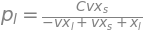

In [14]:
eqn_spot_long = sp.Eq(p_l_s, amm0.spot_price('long'))
eqn_spot_long

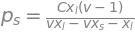

In [15]:
eqn_spot_short = sp.Eq(p_s_s, amm0.spot_price('short')).simplify()
eqn_spot_short

In [16]:
eqn_spot_sum = sp.Eq(
    p_l_s + p_s_s, 
    (amm0.spot_price('long') + amm0.spot_price('short')).simplify())
eqn_spot_sum

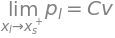

In [17]:
eqn_spot_long_limit = sp.Eq(
    sp.Limit(p_l_s, x_l, x_s), amm0.spot_price('long').subs({x_s: x_l}).simplify())
eqn_spot_long_limit

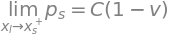

In [18]:
eqn_spot_short_limit = sp.Eq(
    sp.Limit(p_s_s, x_l, x_s), amm0.spot_price('short').subs({x_s: x_l}).simplify())
eqn_spot_short_limit

In [19]:
# print(sp.latex(eqn_spot_long, mode='inline'))

### Balancer Pool Weights
The prices are achieved by dynamically adjusting the Balancer pool weights in response to trades or moves in the underlying asset price.  Below we show the equations for the weights.

In [20]:
d_w = sp.denom(amm0.weights[0])
d_w_s = sp.symbols('Delta')
eqn_balancer_weight_denom = sp.Eq(d_w_s, d_w)
eqn_balancer_weight_denom

In [21]:
eqn_balancer_coin_wt_numer, eqn_balancer_long_wt_numer, eqn_balancer_short_wt_numer = [
    sp.Eq(w_sym, (w*d_w).simplify().collect([x_c, x_l, x_s])/d_w_s) 
    for w_sym, w in zip([w_c, w_l, w_s], amm0.weights)]

In [22]:
eqn_balancer_coin_wt_numer

In [23]:
eqn_balancer_long_wt_numer

In [24]:
eqn_balancer_short_wt_numer

### Effect of trades on token balances and weights
The section below looks at how the token balances and weights change after swap-reweight operation

Comparison with present implementation of same total trade size split multiple trades to do rebalancing 

In [25]:
amm_n = default_simple_setup()
n_trades = 100
total_traded = 10000.
for i in range(n_trades):
    _ = amm_n.swap('coin', total_traded/n_trades, 'long')
amm_n

AMM Balance: 109527.24
 = 101040.11 (safe) + 8487.13 (risk)
 = 20000.00 coin + 810.40 long @ 55.24 (44763.62) + 1000.00 short @ 44.76 (44763.62)
  Cumulative Trades:  Assets 10000.00  Maximum Liabilities 18959.89
  Trade Equity: -8959.89
  LP Token Price: 1.00

# Position Token Price Changes
We can actually work with the expressions for the position token spot prices directly by differentiating
with respect to the asset price $v$.  This gives: 

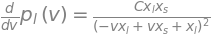

In [26]:
eqn_spot_long_deriv = sp.Eq(
    sp.UnevaluatedExpr(sp.Function('p_l')(v).diff(v)), 
    amm0.spot_price('long').diff(v).simplify())
eqn_spot_long_deriv

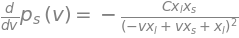

In [27]:
eqn_spot_short_deriv = sp.Eq(
    sp.UnevaluatedExpr(sp.Function('p_s')(v).diff(v)), 
    amm0.spot_price('short').diff(v).simplify())
eqn_spot_short_deriv

In the limit of equal long and short position tokens this leads to the desired linear dependence of spot price change with respect to the underlying asset price:

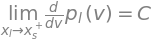

In [28]:
eqn_spot_long_deriv_limit = sp.Eq(
    sp.Limit(sp.UnevaluatedExpr(sp.Function('p_l')(v).diff(v)), x_l, x_s), 
    amm0.spot_price('long').diff(v).subs({x_l: x_s}).simplify())
eqn_spot_long_deriv_limit

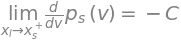

In [29]:
eqn_spot_short_deriv_limit = sp.Eq(
    sp.Limit(sp.UnevaluatedExpr(sp.Function('p_s')(v).diff(v)), x_l, x_s),
    amm0.spot_price('short').diff(v).subs({x_l: x_s}).simplify())
eqn_spot_short_deriv_limit

We can simplify the general form of the spot price derivatives above by introducing a scaling parameter $a$ for the short token balance, $a=1$ corresponds to equal long and short token balances.

In [30]:
a = sp.symbols('a', real=True)
eqn_list_token_rescale = (
    sp.Eq(x_l, x_p), sp.Eq(x_s, a*x_p), 
    sp.Eq(a, sp.solve(sp.Eq(a*x_p, x_p + x_d), a)[0]))
eqn_list_token_rescale

In [31]:
# for eqn in eqn_list_token_rescale:
#     print(sp.latex(eqn, mode='inline'))

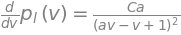

In [32]:
eqn_spot_long_deriv_rescale = sp.Eq(sp.UnevaluatedExpr(sp.Function('p_l')(v).diff(v)),
      amm0.spot_price('long').diff(v).subs({x_l: x_p, x_s: x_p*a}).simplify())
eqn_spot_long_deriv_rescale

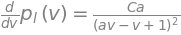

In [33]:
eqn_spot_short_deriv_rescale = sp.Eq(sp.UnevaluatedExpr(sp.Function('p_s')(v).diff(v)),
      amm0.spot_price('short').diff(v).subs({x_l: x_p, x_s: x_p*a}).simplify())
eqn_spot_long_deriv_rescale

We see that the spot prices give the desired $\pm C$ sensitivity to underlying asset price changes (i.e. "futures like") when $a=1$ or when:

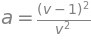

In [34]:
eqn_delta1_scaled_balance = sp.Eq(
    a, sp.expand(sp.solve(sp.Eq(a, (a*v-v+1)**2), a)[1]).factor())
eqn_delta1_scaled_balance

Away from the midpoint of the band at $v=0.5$ the token balances needed for unit slope vary such that

* at $v=0.1$  (i.e. close to floor) need 81 times as much short token as long token
* at $v=0.9$  (i.e. close to cap) need 81 times as much long token as short token

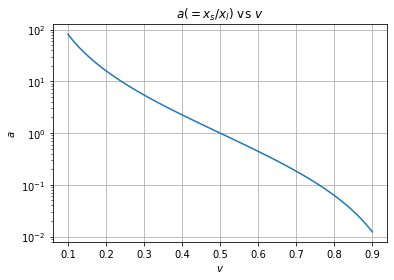

In [35]:
v_np = np.linspace(0.1, 0.9, 100)
a_f = sp.lambdify(v, sp.expand(sp.solve(sp.Eq(a, (a*v-v+1)**2), a)[1]).factor(),  )
_ = plt.semilogy(v_np, a_f(v_np))
_ = plt.grid()
_ = plt.xlabel('$v$')
_ = plt.ylabel('$a$')
_ = plt.title('$a ( = x_s/x_l )$ vs $v$')

Check that there's no value of a that leads to divergence of price gradient
as the underlying price changes. This would occur if the denominator of spot price gradient went to zero.

We see that a would need to be < 0 for this to occur, as v is in range (0,1) so this is ok.

In [36]:
sp.Eq(a, sp.solve(
        sp.denom(amm0.spot_price('long').diff(v).subs({x_l: x_p, x_s: x_p*a}).simplify()), a
    )[0])

# Closed Form Solutions for Swaps
The linearized form of the state change after a swap can actually be solved in closed form!

**This is very important**

The main consequence is that we may be able to replace the existing Balancer swap followed by reweight Balancer pool with the simpler direct approach.  This would reduce slippage and gas costs. (could also make pooled liquidity easier to implement)

A secondary consequence is the marketing angle, new AMM equations/invariants get a lot of interest (or at least used to)

A tertiary consequence is it could be easier to reason about the AMM behaviour in this form, so as to understand risks etc

Still need to include fees, determine equations for other swaps (coin->short, long->coin, short->coin), and ideally an invariant but I feel like the bulk of the problem is solved

## General Form

In [37]:
def simplify_token_balance(amm, token_name, var=None):
    f = sp.symbols('f', positive=True)
    var = var or f
    ind = amm.token_names.index(token_name)
    amm.tokens[ind] = sp.exp(
        sp.expand_log(
            sp.log(amm.tokens[ind].subs({1.: sp.Integer(1)})), force=True
        ).simplify() 
    ).series(var, n=2).removeO().simplify()

In [38]:
def solve_swap(tok_in, tok_out):
    amm = default_simple_setup(x_c, x_l, x_s, v, C)
    amm_tok0 = amm.tokens.copy()
    ind_in = amm.token_names.index(tok_in)
    x_in = amm_tok0[ind_in]
    ind_out = amm.token_names.index(tok_out)
    x_out = amm_tok0[ind_out]
     
    f = sp.symbols('f', positive=True)
    _ = amm.swap(tok_in, f, tok_out)
    simplify_token_balance(amm, tok_out)
    dout_din = [((amm.tokens[i] - amm_tok0[i])/f).simplify() for i in range(3)]
    d_in = sp.symbols(x_in.name.replace('x', 'Delta'), real=True)

    x_out_f = sp.Function(x_out.name)
    x_out_0 = sp.symbols(x_out.name + '0', positive=True)
    x_out_rhs = dout_din[ind_out].subs({x_out: x_out_f(d_in)})
    x_out_ode = sp.Eq(x_out_f(d_in).diff(), x_out_rhs)
    x_out_sol = sp.dsolve(
        x_out_ode, ics={x_out_f(0): x_out_0}).simplify()
        
    x_out_sol_f = sp.lambdify(
        [d_in] + amm_tok0 + [v, C], x_out_sol.rhs.subs({x_out_0: x_out}), 'numpy'
    )

    # Reverse solution to find amount of out token that needs to be swapped for in token
    # e.g. get L -> C swap from C -> L swap solution
    # i.e. getExpectedAmountIn of 
    d_out = sp.symbols(x_out.name.replace('x', 'Delta'), real=True)
    x_in_sol = sp.Eq(d_in, sp.solve(
        x_out_sol.subs(
            {x_out_f(d_in): x_out}
        ), d_in
    )[0].subs({x_out: x_out_0 + d_out}).subs({x_out_0: x_out}).simplify())
    x_in_sol_f = sp.lambdify(
        [d_out] + amm_tok0 + [v, C], x_in_sol.rhs, 'numpy'
    )
    
    # For consistency look at change in out balance i.e. getExpectedAmountOut for amount in 
    x_out_diff_sol = sp.Eq(d_out, (x_out_sol.rhs - x_out_0).simplify().subs({x_out_0: x_out}))
    x_out_diff_sol_f = sp.lambdify(
        [d_in] + amm_tok0 + [v, C], x_out_diff_sol.rhs, 'numpy'
    )
    
    x_in_diff_sol = sp.Eq(d_in, sp.solve(x_out_diff_sol, d_in)[0])
    x_in_diff_sol_f = sp.lambdify(
        [d_out] + amm_tok0 + [v, C], x_in_diff_sol.rhs, 'numpy'
    )
    
    return (
        x_out_sol, x_out_sol_f, x_out_ode, 
        x_in_sol, x_in_sol_f, x_out_diff_sol, x_in_diff_sol, x_out_diff_sol_f, x_in_diff_sol_f
    )

In [39]:
class MettalexSwap:
    def __init__(self, tok_in, tok_out):
        (
            self._x_out_sol, 
            self._x_out_sol_f, 
            self._x_out_ode, 
            self._x_in_sol, 
            self._x_in_sol_f, 
            self._x_out_diff_sol, 
            self._x_in_diff_sol, 
            self._x_out_diff_sol_f, 
            self._x_in_diff_sol_f
        ) = solve_swap(tok_in, tok_out)
        
    def ode(self):
        return self._x_out_ode
    
    def out_balance_eqn(self):
        return self._x_out_sol
    
    def out_balance_fun(self, *args):
        return self._x_out_sol_f(*args)
    
    def out_from_in_eqn(self):
        # Return (positive) amount swapped out
        return sp.Eq(self._x_out_diff_sol.lhs, (-self._x_out_diff_sol.rhs).simplify())
    
    def in_from_out_eqn(self):
        # Return (positive) amount swapped out
        return sp.Eq(self._x_in_diff_sol.lhs, (-self._x_in_diff_sol.rhs).simplify())
    
    def out_from_in_fun(self, *args):
        return -self._x_out_diff_sol_f(*args)
    
    def in_from_out_fun(self, *args):
        return -self._x_in_diff_sol_f(*args)
    

In [40]:
def get_eqn_symbols(eqn):
    return {a.name: a for a in eqn.atoms() if hasattr(a, 'name')}

### Swap Coin for Long

In [41]:
c2l_swap = MettalexSwap('coin', 'long')

Spot price of long token $p_l$ is a function of only the long and short token balances.  For a swap from coin to long token the long token balance can be treated as a function of the coin balance.  It is then possible to solve an ordinary differential equation (ODE) to determine the dependence of the long token balance on amount of coin swapped in to the AMM.

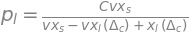

In [42]:
eqn_c2l_spot_price = sp.Eq(p_l_s, (-1/c2l_swap.ode().rhs).simplify())
eqn_c2l_spot_price

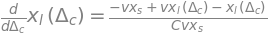

In [43]:
c2l_swap.ode()

Expression for AMM balance of Long tokens after swapping coin in

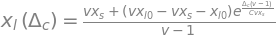

In [44]:
c2l_swap.out_balance_eqn()

Expression for long tokens swapped out after swapping in coin  (NB: the result is a positive number)

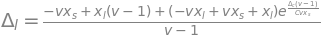

In [45]:
c2l_swap.out_from_in_eqn()
# sol_c2l_d

Expression for coins swapped out after swapping in long tokens (NB: the result is a positive number)

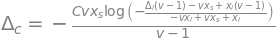

In [46]:
c2l_swap.in_from_out_eqn()

Long tokens left after buying \$10000 worth

In [47]:
c2l_swap.out_balance_fun(10000, 10000, 1000, 1000, 0.5, 100)

Check this agrees with amount swapped out

In [48]:
c2l_swap.out_from_in_fun(
    10000, # Swap in 10_000 coin for x long
    10000, 
    1000, 
    1000, 0.5, 100)

Compare with current implementation breaking the \\$10000 into 10000 trades of \\$1 each to avoid slippage

In [49]:
amm_n = default_simple_setup()
n_trades = 10000
total_traded = 10_000
for i in range(n_trades):
    _ = amm_n.swap('coin', total_traded/n_trades, 'long')
amm_n

AMM Balance: 109483.35
 = 100968.21 (safe) + 8515.14 (risk)
 = 20000.00 coin + 809.68 long @ 55.26 (44741.68) + 1000.00 short @ 44.74 (44741.68)
  Cumulative Trades:  Assets 10000.00  Maximum Liabilities 19031.79
  Trade Equity: -9031.79
  LP Token Price: 1.00

For further comparison we see that doing the trade in a single block results in a large amount of slippage with the current implementation:

In [50]:
amm_n = default_simple_setup()
n_trades = 1
total_traded = 10_000
for i in range(n_trades):
    _ = amm_n.swap('coin', total_traded/n_trades, 'long')
amm_n

AMM Balance: 113079.61
 = 107055.06 (safe) + 6024.55 (risk)
 = 20000.00 coin + 870.55 long @ 53.46 (46539.80) + 1000.00 short @ 46.54 (46539.80)
  Cumulative Trades:  Assets 10000.00  Maximum Liabilities 12944.94
  Trade Equity: -2944.94
  LP Token Price: 1.03

Long tokens balance of AMM after extracting \\$10000 worth of coin 

In [51]:
c2l_swap.out_balance_fun(-10000, 10000, 1000, 1000, 0.5, 100)

Check this agrees with the output amount of coins obtained by swapping in 210 long tokens

In [52]:
c2l_swap.in_from_out_fun(
    210.3418361513, # Swap in 210 long for x coin
    10000, 1000, 1000, 0.5, 100)

### Swap Coin for Short

In [53]:
c2s_swap = MettalexSwap('coin', 'short')

The spot price of short token as a function of coin swapped in similarly defines an ODE that can be solved for short token balance.

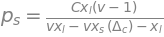

In [54]:
eqn_c2s_spot_price = sp.Eq(p_s_s, (-1/c2s_swap.ode().rhs).simplify())
eqn_c2s_spot_price

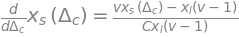

In [55]:
c2s_swap.ode()

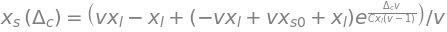

In [56]:
c2s_swap.out_balance_eqn() # sol_c2s

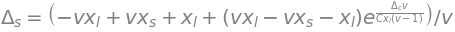

In [57]:
c2s_swap.out_from_in_eqn()

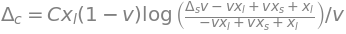

In [58]:
c2s_swap.in_from_out_eqn()

### Swap Long for Short

A direct swap from long to short tokens is not currently allowed by the Mettalex DEX but the ODE can be obtained by combining the coin to long and coin to short equations, or by using the existing implementation and linearizing.  The latter approach is used below however the result agrees with the former approach.  This is reassuring as it implies the absence of arbitrage possibilities.

In [59]:
l2s_swap = MettalexSwap('long', 'short')

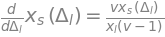

In [60]:
l2s_swap.ode()

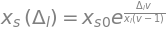

In [61]:
l2s_swap.out_balance_eqn()

In [62]:
# Looks like we have slippage e.g. 500 L in gives < 400 S out - this is good!
l2s_swap.out_balance_fun(500, 10000, 1000, 1000, 0.5, 100)

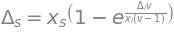

In [63]:
l2s_swap.out_from_in_eqn()

In [64]:
l2s_swap.in_from_out_eqn()

### Swap Short for Long

In [65]:
s2l_swap = MettalexSwap('short', 'long')

In [66]:
s2l_swap.out_balance_eqn()

## Checking for arbitrage opportunities

Check that swap C->L then L->C returns to original state.  Swap in $\Delta_c$ coin then swap in $-\Delta_c$ coin starting from the new state.

In [67]:
d_c = sp.symbols('Delta_c', real=True)

In [68]:
sol_c2l_v = get_eqn_symbols(c2l_swap.out_balance_eqn())
sol_c2l_v

{'x_s': x_s, 'v': v, 'Delta_c': Delta_c, 'x_l0': x_l0, 'C': C}

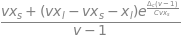

In [69]:
x_l_1 = c2l_swap.out_balance_eqn().rhs.subs(
    {
        sol_c2l_v['x_l0']: x_l,
        sol_c2l_v['x_s']: x_s,
        sol_c2l_v['Delta_c']: d_c,
    }
)
x_l_1

In [70]:
c2l_swap.out_balance_eqn().rhs.subs(
    {
        sol_c2l_v['x_l0']: x_l_1,
        sol_c2l_v['x_s']: x_s,
        sol_c2l_v['Delta_c']: -d_c,
    }
).simplify()

Looks ok, we start with $x_l$ long tokens and after both swaps return to that amount.

Now look at the C->L, L->S, S->C where in last step we remove same amount of coin as original swap in.

In the L->S step we swap all of the long tokens extracted from the AMM in the first swap, this will be $x_{l_{0}} - x_{l_{1}}$ where $x_{l_{1}}$ is the long token balance in AMM after first swap 

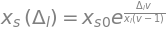

In [71]:
sol_l2s = l2s_swap.out_balance_eqn()
sol_l2s

In [72]:
sol_l2s_v = {a.name: a for a in sol_l2s.atoms() if hasattr(a, 'name')}
sol_l2s_v

{'v': v, 'x_l': x_l, 'x_s0': x_s0, 'Delta_l': Delta_l}

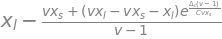

In [73]:
d_x_l_1 = x_l - x_l_1  # Long tokens swapped out in first C-> L step
d_x_l_1

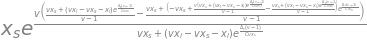

In [74]:
# Swap the long tokens for short, this returns long token balance to original 
x_s_1 = sol_l2s.rhs.subs(
    {
        sol_l2s_v['x_l']: x_l_1,
        sol_l2s_v['x_s0']: x_s,
        sol_l2s_v['Delta_l']: d_x_l_1,
    }
)
x_s_1

In [75]:
sol_c2s = c2s_swap.out_balance_eqn()

In [76]:
sol_c2s_v = {a.name: a for a in sol_c2s.atoms() if hasattr(a, 'name')}
sol_c2s_v

{'v': v, 'x_l': x_l, 'x_s0': x_s0, 'Delta_c': Delta_c, 'C': C}

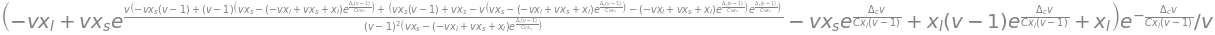

In [77]:
x_s_2 = sol_c2s.rhs.subs(
    {
        sol_c2s_v['x_l']: x_l,
        sol_c2s_v['x_s0']: x_s_1,
        sol_c2s_v['Delta_c']: -d_c,
    }
)
(x_s_2 - x_s).simplify()

Not immediately simplifying to zero - try some numeric values

In [78]:
x_s_2_v = {a.name: a for a in x_s_2.atoms() if hasattr(a, 'name')}
x_s_2_v

{'x_s': x_s, 'v': v, 'x_l': x_l, 'Delta_c': Delta_c, 'C': C}

In [79]:
x_s_0 = 1000
x_s_2.subs(
    {
        x_s_2_v['x_l']: 1000,
        x_s_2_v['x_s']: x_s_0,
        x_s_2_v['Delta_c']: 100,
        x_s_2_v['C']: 100,
        x_s_2_v['v']: 0.8,
    }
).simplify() - x_s_0

Ok, looks like it is zero up to numerical precision.  Good!

# Appendix
Some helper code to generate $\LaTeX$ forms of the key swap equations.

In [80]:
print(f"Coin to Long swap: {sp.latex(c2l_swap.out_from_in_eqn(), mode='inline')}\n")
print(f"Long to Coin swap: {sp.latex(c2l_swap.in_from_out_eqn(), mode='inline')}\n")
print(f"Coin to Short swap: {sp.latex(c2s_swap.out_from_in_eqn(), mode='inline')}\n")
print(f"Short to Coin swap: {sp.latex(c2s_swap.in_from_out_eqn(), mode='inline')}\n")
print(f"Long to Short swap: {sp.latex(l2s_swap.out_from_in_eqn(), mode='inline')}\n")
print(f"Short to Long swap: {sp.latex(s2l_swap.out_from_in_eqn(), mode='inline')}\n")

Coin to Long swap: $\Delta_{l} = \frac{- v x_{s} + x_{l} \left(v - 1\right) + \left(- v x_{l} + v x_{s} + x_{l}\right) e^{\frac{\Delta_{c} \left(v - 1\right)}{C v x_{s}}}}{v - 1}$

Long to Coin swap: $\Delta_{c} = - \frac{C v x_{s} \log{\left(- \frac{\Delta_{l} \left(v - 1\right) - v x_{s} + x_{l} \left(v - 1\right)}{- v x_{l} + v x_{s} + x_{l}} \right)}}{v - 1}$

Coin to Short swap: $\Delta_{s} = \left(- v x_{l} + v x_{s} + x_{l} + \left(v x_{l} - v x_{s} - x_{l}\right) e^{\frac{\Delta_{c} v}{C x_{l} \left(v - 1\right)}}\right) / v$

Short to Coin swap: $\Delta_{c} = C x_{l} \left(1 - v\right) \log{\left(\frac{\Delta_{s} v - v x_{l} + v x_{s} + x_{l}}{- v x_{l} + v x_{s} + x_{l}} \right)} / v$

Long to Short swap: $\Delta_{s} = x_{s} \left(1 - e^{\frac{\Delta_{l} v}{x_{l} \left(v - 1\right)}}\right)$

Short to Long swap: $\Delta_{l} = x_{l} \left(1 - e^{\Delta_{s} \left(v - 1\right) / v x_{s}}\right)$



# Two Token Mettalex - swap and mint concurrently
The need for coin in the AMM can be avoided if the coin swapped in to the AMM is immediately used to mint long and short token pairs.  This reduces the DEX to a custom AMM for long and short token swaps plus the existing vault for converting coin to long and short token pairs.  

Going through the math below it looks like the final simple closed form solution unfortunately doesn't retain the desired spot price depence for the position tokens.

In [81]:
v, C = sp.symbols('v C', positive=True)
s = sp.symbols('s', real=True)
x_l, x_s = sp.symbols('x_l x_s', cls=sp.Function)
x_l0, x_s0 = sp.symbols('x_l0 x_s0', nonnegative=True)
t, u = sp.symbols('t u', real=True)

Consider coin to long swap.  The amount of short token held by the AMM increases linearly as coin is swapped in and used for minting long and short token pairs.

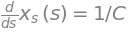

In [82]:
eqn_x_s_mint_swap = sp.Eq(x_s(s).diff(), 1/C)
eqn_x_s_mint_swap

The amount of long token held by AMM is assumed to decrease at same rate as described above, but now has an extra term for the long tokens minted from input coin.  Looking at the final result for position token spot prices this may not be correct.

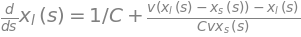

In [83]:
eqn_x_l_mint_swap = sp.Eq(x_l(s).diff(), 1/C + ( v*(x_l(s) - x_s(s)) - x_l(s))/(C*v*x_s(s)))
eqn_x_l_mint_swap

Solve for the short token balance

In [84]:
x_s_sol = sp.dsolve(eqn_x_s_mint_swap, ics={x_s(0): x_s0})
x_s_sol

Substitute the solution for short token balance as a function of coin swapped in $s$ into the ODE for long token balance

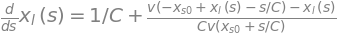

In [85]:
eqn_x_l_mint_swap_subs = eqn_x_l_mint_swap.subs({x_s(s): x_s_sol.rhs})
eqn_x_l_mint_swap_subs

Solve the ODE

In [86]:
sol_x_l_mint_swap = sp.dsolve(eqn_x_l_mint_swap_subs, ics={x_l(0): x_l0}).simplify()
sol_x_l_mint_swap

SImplify result

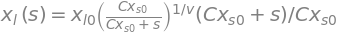

In [87]:
non_exp_factor_x_l = x_l0*(C*x_s0 + s)/(C*x_s0)
# sp.powsimp((
sol_x_l_mint_swap_rhs_exp_simp = sp.exp(
    sp.logcombine(
        sp.expand_log(
            sp.log(sol_x_l_mint_swap.rhs/(non_exp_factor_x_l)), force=True
        ), force=True
    )
)*non_exp_factor_x_l 
sp.Eq(sol_x_l_mint_swap.lhs, sol_x_l_mint_swap_rhs_exp_simp)

In [88]:
sol_x_l_mint_swap_rhs_full_simp = sp.powsimp((sol_x_l_mint_swap_rhs_exp_simp /x_l0).subs({C*x_s0: t}).subs({t/(s+t): u, (s+t)/t: 1/u})).subs({u: t/(s+t)}).subs({t: C*x_s0})*x_l0
eqn_x_l_swap_mint_sol = sp.Eq(sol_x_l_mint_swap.lhs, sol_x_l_mint_swap_rhs_full_simp)
eqn_x_s_swap_mint_sol = x_s_sol

Final form for AMM long and short token balances after swapping in $s$ coin

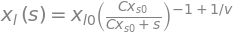

In [89]:
eqn_x_l_swap_mint_sol

In [90]:
eqn_x_s_swap_mint_sol

Check the spot price - looks like this does not equal the expected $v C$

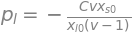

In [91]:
sp.Eq(p_l_s, -1/eqn_x_l_swap_mint_sol.rhs.series(s, n=2).coeff(s).simplify())

So this isn't quite the correct form of the system of ODEs.  The mistake was adding the newly minted long tokens to the AMM, should they go to the user?  Unclear whether this would fix things and in any event SymPy struggles to solve the resulting ODE.  

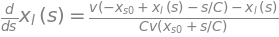

In [92]:
eqn_x_l_mint_swap_correct = sp.Eq(x_l(s).diff(), ( v*(x_l(s) - x_s(s)) - x_l(s))/(C*v*x_s(s))).subs({x_s(s): x_s_sol.rhs})
eqn_x_l_mint_swap_correct

In [93]:
# Hangs
# sol_x_l_mint_swap_correct = sp.dsolve(eqn_x_l_mint_swap_correct, ics={x_l(0): x_l0}).simplify()
# sol_x_l_mint_swap_correct

# Two Token Mettalex - mint L + S, swap unwanted
An alternative two token AMM approach is to only allow swaps between long and short tokens using the existing solution.  This means a trader desiring say long exposure will mint long and short token pairs, then swap the unwanted short tokens for long.  This case is considered below.

## Swap C $\rightarrow$ L via C $\rightarrow$ L + S mint
First we see the amount of long tokens returned in exchange for $\Delta_s$ short tokens

In [94]:
s2l_swap.out_from_in_eqn()

In [95]:
s2l_swap_syms = get_eqn_symbols(s2l_swap.out_from_in_eqn())
s2l_swap_syms

{'x_s': x_s, 'v': v, 'x_l': x_l, 'Delta_l': Delta_l, 'Delta_s': Delta_s}

Total amount of long token returned to user for $s$ coin in will be $s/C$ long tokens from minting plus result of swapping $s/C$ short tokens minted for long tokens.

In [96]:
eqn_mint_s2l_swap = sp.Eq(
    x_l(s), (s/C + s2l_swap.out_from_in_eqn().rhs.subs({s2l_swap_syms['Delta_s']: s/C})).simplify()
)
eqn_mint_s2l_swap

The long token spot price now appears to have correct form

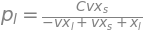

In [97]:
sp.Eq(p_l_s, 1/eqn_mint_s2l_swap.rhs.series(s, n=2).coeff(s).simplify())

In [98]:
mint_s2l_swap_f = sp.lambdify(
    [s, s2l_swap_syms['x_l'], s2l_swap_syms['x_s'], v, C], 
    eqn_mint_s2l_swap.rhs, 'numpy'
)

Look at swap 10,000 coin for long token at spot price of $v=0.5$ using the mint-swap approach with 1000 long and 1000 short tokens initially in AMM (and no coin).  With no slippage 200 long tokens would be optained.

In [99]:
mint_s2l_swap_f(10_000, 1000, 1000, 0.5, 100) 

Compare with the closed form derived above, assuming 100000 coin as well as the long and short tokens in the amm.  This is double the liquidity compared to the mint-swap approach however we see the slippage is increased. 

In [100]:
c2l_swap.out_from_in_fun(10_000, 100_000, 1000, 1000, 0.5, 100)

Finally, compare with existing implementation of Balancer swap then reweight.  We see increased slippage if the order is executed as a single swap, although this could be reduced by breaking the order into smaller pieces.

In [101]:
default_simple_setup(100_000, 1000, 1000, 0.5, 100).swap('coin', 10_000, 'long')

DEX: Trade 10000.00 coin for 173.55 long at initial spot 50.00 (-fair price = 0.00), trade price 57.62, post-trade spot 66.55, final spot 54.75

# Swap L $\rightarrow$ C via L $\rightarrow$ S swap, redeem L + S

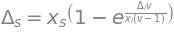

In [102]:
l2s_swap.out_from_in_eqn()

In [103]:
l2s_swap_syms = get_eqn_symbols(l2s_swap.out_from_in_eqn())

Start with $s$ long tokens we fraction $a$ of these for short tokens with the constraint that the number of short tokens recevied must equal the unswapped long tokens $1-a$ in order to redeem as pairs.

In [104]:
eqn_l2c_pair = sp.Eq((1-a)*s, l2s_swap.out_from_in_eqn().rhs.subs({l2s_swap_syms['Delta_l']: a*s}))
eqn_l2c_pair

Unfortunately the equation above does not have a closed form solution for $a$ so numerical methods must be used instead to deermine what fraction of the input long token to swap for short.

In [105]:
def f_l2c_swap_redeem(s_val, x_l_val, x_s_val, v_val, C_val):
    return (eqn_l2c_pair.lhs - eqn_l2c_pair.rhs).subs(
        {s: s_val, l2s_swap_syms['x_l']: x_l_val, l2s_swap_syms['x_s']: x_s_val,
        v: v_val, C: C_val}
    )

In [106]:
s_val = 100
a_s = float(sp.nsolve(f_l2c_swap_redeem(s_val, 1000, 1000, 0.5, 100), 0.5))
a_s

In [107]:
a_s*s_val

In [108]:
l2s_swap.out_from_in_fun(s_val*a_s, 100_000, 1000, 1000, 0.5, 100)

In [109]:
s_val*(1-a_s)

In [110]:
def l2c_swap_redeem_coin_out_f(s_val, x_l_val, x_s_val, v_val, C_val):
    a_s = float(sp.nsolve(f_l2c_swap_redeem(s_val, x_l_val, x_s_val, v_val, C_val), 0.5))
    return (1-a_s)*s_val*C_val, a_s

In [111]:
s_val = 100
# Price per token sold
l2c_swap_redeem_coin_out_f(s_val, 1000, 1000, 0.5, 100)[0]/s_val